# An Analysis of Efficient Connect 4 AI Solvers
**Kevin Ye**

_Advanced Artificial Intelligence_ <br>
May 23, 2020

### Background of Connect 4
<!-- ![connect4.png](connect4.png) -->
<img src="connect4.png" width="240" height="240" align="right"/>

Connect 4 is a two player game with perfect information, as both players know complete information of the entire game at any state in time. Players also know available moves as well.

Connect 4 is a zero-sum game, since any move one player makes directly affects the outcome of the other. 

Played on a 7x6 board, typically with red and yellow pieces, there are 4,531,985,219,092 possible positions for the game. Examining the game tree for a standard machine without any optimizations would be intractable for a search space of this size, as it expands exponentially. The search space is upper bounded by 3^42, but there are actually fewer since there are certain positions that are not possible/reachable due to the rules of the game (priority column-ordering when making a move, and the player order).

### Motiation of Connect 4 AI
This game has been extensively studied for game theory and AI, and the earliest tree-based AI engines were developed on these relatively simple games. Although not as cutting edge and recent as reinfocement learning, neural nets, and Q-learning, we want to explore these seeminly simple, yet fundamental techineques, in Connect 4. This will help us learn about and examine search/time complexity, reduction in bottlenecks/repeated calls, various heuristics for making an (or estimated) optimal choice, and optimization in the tree search.

### Goals
Our goal in this project is to explore the different types of search methods (with minimax, alpha-beta pruning, cacheing) to play Connect 4. We want to analyze our results of the game playing itself with different heuristics as well as different levels of search depth.

We are comparing the differences between the baseline minimax tree search algorithm to it improved counterparts. This includes the introduction of a very powerful technique of reducing the tree size by pruning, known as alpha-beta pruning. We will also compare to a common computation techinque of cacheing, also known as memoization, of already computed nodes/states. We also attempt to compare other optimizations as discussed further.

Some benchmarks will be to measure the time taken to compute up to a certain depth, as well as the number of nodes explored.

We'll compare different heuristics like:
- user
- random play
- standard minimax
- minimax with alpha-beta pruning
- minimax with alpha-beta pruning with a cutoff condition
- minimax with alpha-beta pruning with a cutoff condition and cacheing
- minimax with improved branch prediction (i.e. alpha beta pruning works optimally if the best branch is chosen first). Middle priority 

### Optimizations:
- Alpha-Beta Pruning
    - Motivation of AB pruning is to, for each node in the tree, determine valid ranges that the answer of the current node could be while having potentially considered other child nodes.
    - The intuition is the current node, as a maxinming node, and for a child (say minimizing child), if I've determined its score s1, then all future (better choices) for my other remaining children must be at least s1 for me to consider, or less than s1 from other minimizing childrens' perspective - hence updating the remaining childrens' beta value. If the children update their AB values and the ranges don't intersect anymore (<=), then continued search along subsequent subtrees can stop because those AB values, which are constantly updated via the results of their children nodes, determine possible values that the current subtree's eventual value could take on. Aka, if no intersecting ranges, then we can short circuit remaining depths using already calculated information at least at this depth.
    - If the bounds rule fails, that means that somewhere there was a better option for the parent somewhere earlier in the parent's subtrees. No point in continuing to search the remaining children to find better values for this node, as the mere fact of minimax VIA AB gives rise to the A >= B rule.
    - Algorithm follows as given a subtree and known bounds that a valid answer exists, we can recursively look deeper in the tree and update the best answer as well as valid bounds to help short circuit our search. This will ultimately be called on the top level root tree.
    - AB with picking best choice via heuristic, i.e. exploration order:
        - Heuristics:
            - pick middle column
            - Number of best opportunities

- We can optimize with caching (transposition tables & Python LRU Cache)
    - This is essentially a memoization technique of using a cache of transposition tables
    - LRU Caching with the Python decorator that wraps a function with a memoized lookup, we can test different sizes of caches for repeated I/O bound or expensive functions
    - The reduction of search space, or the number of nodes in the tree can be reduced from a factor of O(b^d) = 7^42 ~ 1e20 to O(N), assumming N is the number of unique board orientations possible. (4,531,985,219,092) [source - wiki & TDS]
    - It's important that if we're trying to cache on AB, then we don't cache the AB arguments, as they are only an instrument solely in AB-pruning to help us short circuit subtrees (prune) but not unique parameters for identifying the computed value/utility of a certain game state. Although there are techniques for utilizing alpha/beta parameters in cacheing, we do not use this in our testing.


### Computation
Python has relatively larger overhead than say C++, but for the sake of implmentation simplicity and familiarity, we went with Python.

Implementation of the code is a variation of the python framework discussed in [Artificial Intelligence: A Modern Approach](https://github.com/aimacode/aima-python/blob/master/games.py).

### Future Considerations for improvement included:
- Multi-threading, but given the large overhead of threads and the less-than-ideal ability to be parallelizable, there would not be much of an improvement.
- Bitboard, which is very fast constant checking of whether someone has won, but was not implemented in this version. 
- Early stopping for the very end depending on if someone is about to win with three positions lined up (not necessarily in a row) such that the next player could win.
- Optimial leaf traversal, i.e. picking the best choice first, to help aid in alpha-beta pruning efficiency.
- Refactor and reduce some of the alpha-beta code to a negamax variant

### References
https://github.com/aimacode/aima-python

https://tromp.github.io/c4/c4.html

https://towardsdatascience.com/creating-the-perfect-connect-four-ai-bot-c165115557b0

http://blog.gamesolver.org/solving-connect-four/07-transposition-table/

In [ ]:
import random
from collections import Counter

import numpy as np
from tqdm import tqdm
import functools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Abstract class for a game

In [ ]:
class Game:
    """A game is similar to a problem, but it has a utility for each
    state and a terminal test instead of a path cost and a goal
    test. To create a game, subclass this class and implement actions,
    result, utility, and is_terminal. You may override display and
    successors or you can inherit their default methods. You will also
    need to set the .initial attribute to the initial state; this can
    be done in the constructor."""

    def actions(self, state):
        """Return a list of the allowable moves at this point."""
        raise NotImplementedError

    def result(self, state, move):
        """Return the state that results from making a move from a state."""
        raise NotImplementedError

    def utility(self, state, player):
        """Return the value of this final state to player."""
        raise NotImplementedError

    def is_terminal(self, state):
        """Return True if this is a final state for the game."""
        return not self.actions(state)

    def to_move(self, state):
        """Return the player whose move it is in this state."""
        return state.to_move

    def display(self, state):
        """Print or otherwise display the state."""
        print(state)
        
        
    def play_game(game, strategies: dict, verbose=False):
        """Play a turn-taking game. `strategies` is a {player_name: function} dict,
        where function(state, game) is used to get the player's move."""
        state = game.initial
        while not game.is_terminal(state):
            print("++beginning of loop")
            player = state.to_move
            move = strategies[player](game, state)
            state = game.result(state, move)
            if verbose: 
                print('Player', player, strategies[player].__name__, 'move:', move)
                print(game.display(state))
                print("utility", state.utility)
            print("--end of loop")
        print(game.display(state))

In [5]:
class Board():
    """A board has the player to move, a cached utility value, 
    and a dict of {(x, y): player} entries, where player is 'X' or 'O'."""
    empty = '.'
    off = '#'
    
    def __init__(self, width=8, height=8, to_move=None, utility=0, board={}):
        self.width = width
        self.height = height
        self.to_move = to_move
        self.utility = utility
        self.board = board
    
    def copy(self):
        boardCopy = self.board.copy()
        b = Board(width=self.width, height=self.height, board=boardCopy)
        return b
    
    def __hash__(self):
        h = hash(tuple(sorted(self.board.items()))) + hash(self.to_move)
        return h
    
    def __eq__(self, other):
        return self.board == other.board and self.to_move == other.to_move
    
    def __str__(self):
        board = self.board
        def row(y): return ''.join(board.get((x, y), '.') for x in range(1, self.width + 1))
        return '\n'.join(map(row, reversed(range(1, self.height + 1)))) + '\n'

### Instantiation of a TicTacToe

In [6]:
class TicTacToe(Game):
    """Play TicTacToe on an h x v board, with Max (first player) playing 'X'.
    A state has the player to move, a cached utility, a list of moves in
    the form of a list of (x, y) positions, and a board, in the form of
    a dict of {(x, y): Player} entries, where Player is 'X' or 'O'."""

    def __init__(self, width=3, height=3, k=3):
        self.k = k
        self.squares = a = {(x, y) for x in range(1, width + 1)
                for y in range(1, height + 1)} # All available that can be played at some given time
        self.initial = Board(width=width, height=height, to_move='X', utility=0) #GameState(to_move='X', utility=0, board={}, moves=moves)

    def actions(self, state):
        """Legal moves are any square not yet taken."""
        return self.squares - set(state.board)

    def result(self, state, move) -> 'Board':
        if move not in self.actions(state):
            print(move)
            print("illegal")
            return state  # Illegal move has no effect
        newState = state.copy()
        newState.board.update({move: state.to_move})
        newState.to_move = ('O' if state.to_move == 'X' else 'X')
        newState.utility = self.compute_utility(newState.board, move, state.to_move)
        return newState
    
    def utility(self, state, player):
        """Return the value to player; 1 for win, -1 for loss, 0 otherwise."""
        return state.utility if player == 'X' else -state.utility

    def is_terminal(self, state):
        """A state is terminal if it is won or there are no empty squares."""
        return state.utility != 0 or len(self.actions(state)) == 0

    def display(self, state):
        print(state)

    def compute_utility(self, board, move, player):
        """If 'X' wins with this move, return 1; if 'O' wins return -1; else return 0.
        Right now, this is a simple solver, where it only returns non-zero for someone
        winning. Intermediate game states that cannot be determined currently have a
        score of 0.
        """
        if (self.k_in_row(board, move, player, (0, 1)) or
                self.k_in_row(board, move, player, (1, 0)) or
                self.k_in_row(board, move, player, (1, -1)) or
                self.k_in_row(board, move, player, (1, 1))):
            return +1 if player == 'X' else -1
        else:
            return 0

    def k_in_row(self, board, move, player, delta_x_y):
        """Return true if there is a line through move on board for player.
        Could be improved with a bitboard.
        """
        (delta_x, delta_y) = delta_x_y
        x, y = move
        n = 0  # n is number of moves in row
        while board.get((x, y)) == player:
            n += 1
            x, y = x + delta_x, y + delta_y
        x, y = move
        while board.get((x, y)) == player:
            n += 1
            x, y = x - delta_x, y - delta_y
        n -= 1  # Because we counted move itself twice
        return n >= self.k    

### ConnectFour game, subclassing the TicTacToe game.

In [ ]:
class ConnectFour(TicTacToe):
    """A TicTacToe-like game in which you can only make a move on the bottom
    row, or in a square directly above an occupied square.  Traditionally
    played on a 7x6 board and requiring 4 in a row."""

    def __init__(self, width=7, height=6, k=4):
        TicTacToe.__init__(self, width, height, k)

    def actions(self, state):
        return {(x, y) for (x, y) in self.squares - set(state.board)
                if y == 1 or (x, y - 1) in state.board}

### Helper Functions
#### AI heuristics

In [8]:
cache = functools.lru_cache(10**9)

def cache1(function):
    "Like lru_cache(None), but only considers the first argument of function."
    cache = {}
    def wrapped(x, *args):
        if x not in cache:
            cache[x] = function(x, *args)
        return cache[x]
    return wrapped

In [9]:
def minmax_decision(game, state):
    """Given a state in a game, calculate the best move by searching
    forward all the way to the terminal states. [Figure 5.3]"""

    player = game.to_move(state)
    
    def max_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a))
            if v2 > v:
                v, move = v2, a
        return v, move

    def min_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a))
            if v2 < v:
                v, move = v2, a
        return v, move

    return max_value(state)


def minmax_decision_cache(game, state):
    """Given a state in a game, calculate the best move by searching
    forward all the way to the terminal states. [Figure 5.3]"""

    player = game.to_move(state)
    
    @cache
    def max_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a))
            if v2 > v:
                v, move = v2, a
        return v, move

    @cache
    def min_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a))
            if v2 < v:
                v, move = v2, a
        return v, move

    return max_value(state)

def alpha_beta_search(game, state):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = game.to_move(state)

    # Functions used by alpha_beta
    def max_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    def min_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -np.inf, +np.inf)

def alpha_beta_search_cache(game, state):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = game.to_move(state)

    # Functions used by alpha_beta
    @cache1
    def max_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    @cache1
    def min_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -np.inf, +np.inf)

def cut(d):
    return lambda game, state, depth: depth >= d

def alpha_beta_cutoff_search(game, state, cutoff=cut(8), eval_fn=(lambda state, player: 0)):
    """Search game to determine best action; use alpha-beta pruning.
    This version cuts off search and uses an evaluation function.
    eval_fn: gives a default method to evaluate a board if reached a cutoff depth/node
    """
    
    player = game.to_move(state)

    # Functions used by alpha_beta
    def max_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return eval_fn(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta, depth+1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move
    
    def min_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return eval_fn(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -np.inf, +np.inf, 0)


def alpha_beta_cutoff_search_cache(game, state, cutoff=cut(8), eval_fn=(lambda state, player: 0)):
    """Search game to determine best action; use alpha-beta pruning.
    This version cuts off search and uses an evaluation function.
    eval_fn: gives a default method to evaluate a board if reached a cutoff depth/node
    """
    
    player = game.to_move(state)

    # Functions used by alpha_beta
    @cache1
    def max_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return eval_fn(state, player), None
        v, move = -np.inf, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    @cache1
    def min_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return eval_fn(state, player), None
        v, move = +np.inf, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -np.inf, +np.inf, 0)

### Test Framework
Counting the number of function calls to terminal node and utility evaulation.

In [11]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
    
    # Record attribute misses with wrapper class that doesn't have functions.
    # Or we could use __getattributes__
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)
    
def report(game, searchers):
    l = []
    for i, searcher in enumerate(searchers):
        mapping = {}
        game = CountCalls(game)
        b = %time searcher(game, game.initial)
        mapping['depth'] = i
        mapping['result'] = game._counts['result']
        mapping['terminal'] = game._counts['is_terminal']
        print('Test {}: Result states: {:7,d}; Terminal tests: {:7,d}; for {}'.format(i, 
            game._counts['result'], game._counts['is_terminal'], searcher.__name__))
        print()
        l.append(mapping)
        
    df = pd.DataFrame(l)
    print(df)
    return df

### Run Tests

In [12]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["lines.linewidth"] = 2

pd.set_option('display.max_rows', 50)

In [14]:
# tests = [lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(0)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(0)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(1)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(1)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(2)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(2)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(3)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(3)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(4)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(4)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(5)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(5)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(6)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(6)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(7)),
#          lambda game, state, **kwargs: alpha_beta_cutoffaa_search_cache(game, state, cutoff=cut(7)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(8)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(8)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(9)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(0)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(10)),
#          lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(10)),
#         ] # Add tests to list to run


tests = [lambda game, state, **kwargs: minmax_decision(game, state),
         lambda game, state, **kwargs: minmax_decision_cache(game, state),
         lambda game, state, **kwargs: alpha_beta_search(game, state),
         lambda game, state, **kwargs: alpha_beta_search_cache(game, state),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(7)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(7))
        ] # Add tests to list to run

In [15]:
df1 = report(TicTacToe(), tests)

CPU times: user 5.07 s, sys: 8.29 ms, total: 5.08 s
Wall time: 5.09 s
Test 0: Result states: 549,945; Terminal tests: 549,946; for <lambda>

CPU times: user 197 ms, sys: 2.01 ms, total: 199 ms
Wall time: 199 ms
Test 1: Result states:  16,167; Terminal tests:   5,478; for <lambda>

CPU times: user 462 ms, sys: 983 µs, total: 463 ms
Wall time: 464 ms
Test 2: Result states:  33,142; Terminal tests:  33,143; for <lambda>

CPU times: user 126 ms, sys: 1.12 ms, total: 127 ms
Wall time: 128 ms
Test 3: Result states:   6,532; Terminal tests:   3,592; for <lambda>

CPU times: user 261 ms, sys: 951 µs, total: 262 ms
Wall time: 262 ms
Test 4: Result states:  14,983; Terminal tests:  14,984; for <lambda>

CPU times: user 116 ms, sys: 1.22 ms, total: 117 ms
Wall time: 118 ms
Test 5: Result states:   5,193; Terminal tests:   3,049; for <lambda>

   depth  result  terminal
0      0  549945    549946
1      1   16167      5478
2      2   33142     33143
3      3    6532      3592
4      4   14983     

In [16]:
df1.rename(columns={'depth':'type'}, inplace=True)
df1.loc[0, 'type'] = 'minimax'
df1.loc[1, 'type'] = 'minimax_cache'
df1.loc[2, 'type'] = 'AB'
df1.loc[3, 'type'] = 'AB_cache'
df1.loc[4, 'type'] = 'AB_cut (d=7)'
df1.loc[5, 'type'] = 'AB_cut_cache (d=7)'
df1

,type,result,terminal
0,minimax,549945,549946
1,minimax_cache,16167,5478
2,AB,33142,33143
3,AB_cache,6532,3592
4,AB_cut (d=7),14983,14984
5,AB_cut_cache (d=7),5193,3049


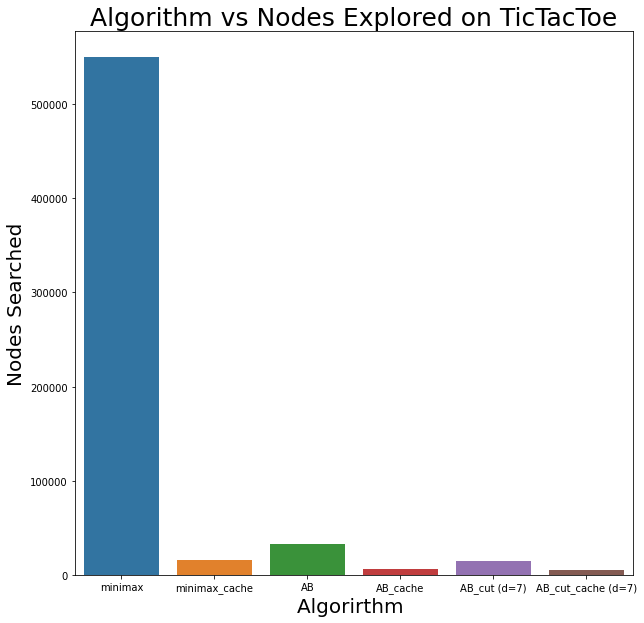

In [24]:
ax = sns.barplot(x='type', y='result', data=df1)
ax.set_ylabel('Nodes Searched',fontsize=20) 
ax.axes.set_title("Algorithm vs Nodes Explored on TicTacToe", fontsize=25)
ax.set_xlabel("Algorirthm ",fontsize=20)
plt.savefig("Algorithm vs Nodes Explored.png", dpi=300)

In [19]:
tests = [lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(0)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(1)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(2)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(3)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(4)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(5)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(6)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(7)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(8)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(9)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(10)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(11)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search(game, state, cutoff=cut(12)),         
        ]
tests2 = [lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(0)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(1)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(2)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(3)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(4)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(5)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(6)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(7)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(8)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(9)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(10)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(11)),
         lambda game, state, **kwargs: alpha_beta_cutoff_search_cache(game, state, cutoff=cut(12)),         
        ]
AB_cut = report(ConnectFour(), tests)
AB_cut_cache = report(ConnectFour(), tests2)

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 38.9 µs
Test 0: Result states:       0; Terminal tests:       1; for <lambda>

CPU times: user 261 µs, sys: 0 ns, total: 261 µs
Wall time: 265 µs
Test 1: Result states:       7; Terminal tests:       8; for <lambda>

CPU times: user 757 µs, sys: 1e+03 ns, total: 758 µs
Wall time: 760 µs
Test 2: Result states:      20; Terminal tests:      21; for <lambda>

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.84 ms
Test 3: Result states:      75; Terminal tests:      76; for <lambda>

CPU times: user 7.83 ms, sys: 136 µs, total: 7.97 ms
Wall time: 7.98 ms
Test 4: Result states:     172; Terminal tests:     173; for <lambda>

CPU times: user 26.1 ms, sys: 893 µs, total: 27 ms
Wall time: 26.4 ms
Test 5: Result states:     563; Terminal tests:     564; for <lambda>

CPU times: user 59.2 ms, sys: 984 µs, total: 60.1 ms
Wall time: 60.2 ms
Test 6: Result states:   1,248; Terminal tests:   1,249; for <lambda>

CPU times: user

In [20]:
concatenated = pd.concat([AB_cut.assign(dataset='AB_cut'), AB_cut_cache.assign(dataset='AB_cut_cache')])
concatenated

,depth,result,terminal,dataset
0,0,0,1,AB_cut
1,1,7,8,AB_cut
2,2,20,21,AB_cut
3,3,75,76,AB_cut
4,4,172,173,AB_cut
5,5,563,564,AB_cut
6,6,1248,1249,AB_cut
7,7,6004,6005,AB_cut
8,8,13657,13658,AB_cut
9,9,83442,83443,AB_cut


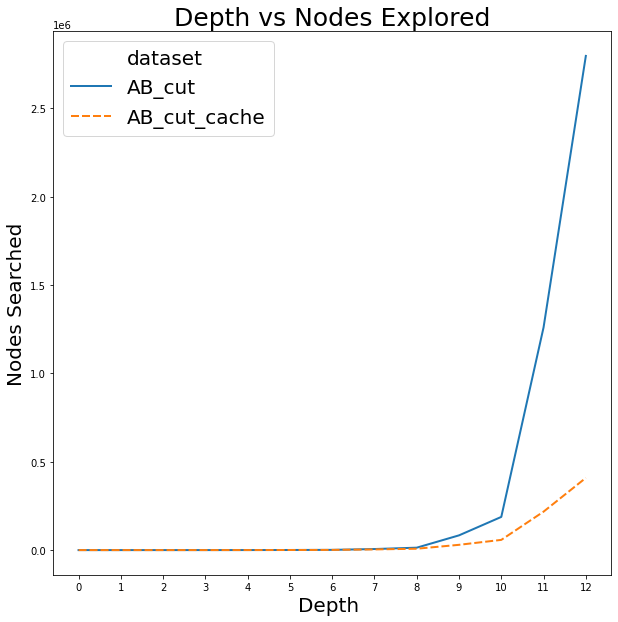

In [22]:
ax = sns.lineplot(x="depth", y="result", hue='dataset', data=concatenated, style="dataset", markers=False, dashes=True)
ax.set_ylabel('Nodes Searched',fontsize=20) 
ax.axes.set_title("Depth vs Nodes Explored", fontsize=25)
ax.set_xlabel("Depth ",fontsize=20)
ax.legend(fontsize = 20)
ax.xaxis.set_ticks(np.arange(0, 13, 1))
plt.savefig("Depth-Nodes_linear.png", dpi=300)

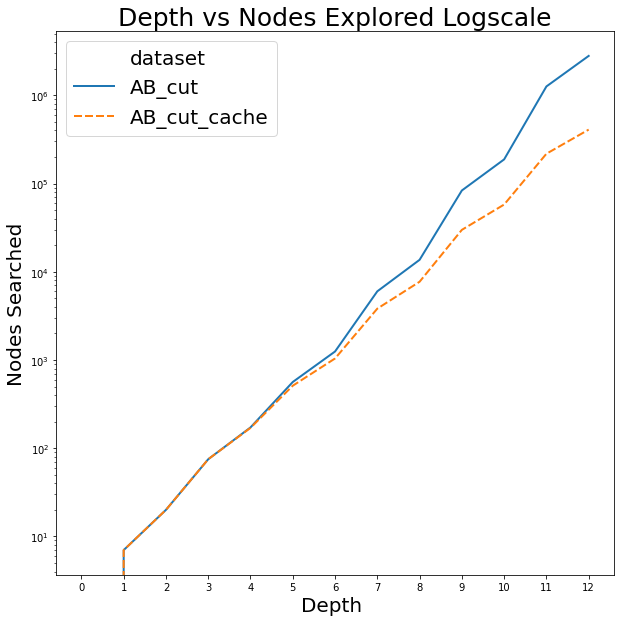

In [23]:
ax = sns.lineplot(x="depth", y="result", hue='dataset', data=concatenated, style="dataset", markers=False, dashes=True)
ax.set_ylabel('Nodes Searched',fontsize=20) 
ax.axes.set_title("Depth vs Nodes Explored Logscale", fontsize=25)
ax.set(yscale="log")
ax.set_xlabel("Depth ",fontsize=20)
ax.legend(fontsize = 20)
ax.xaxis.set_ticks(np.arange(0, 13, 1))
plt.savefig("Depth-Nodes_logscale.png", dpi=300)

### Players

In [87]:
def query_player(game, state):
    """Make a move by querying standard input."""
    print("Current state:")
    game.display(state)
    print("Available moves: {}".format(game.actions(state)))
    print("")
    move = None
    if game.actions(state):
        move_string = input('Your move? ')
        try:
            move = eval(move_string)
        except NameError:
            move = move_string
    else:
        print('no legal moves: passing turn to next player')
    return move

def random_player(game, state):
    return random.choice(tuple(game.actions(state))) if game.actions(state) else None

def player(search_algorithm):
    """A game player who uses the specified search algorithm"""
    return lambda game, state: search_algorithm(game, state)[1]

In [112]:
%time ConnectFour().play_game(dict(X=query_player, O=player(alpha_beta_cutoff_search_cache)), verbose=True)

++beginning of loop
Current state:
.......
.......
.......
.......
.......
.......

Available moves: {(7, 1), (6, 1), (3, 1), (2, 1), (5, 1), (4, 1), (1, 1)}

Your move? 4,1
Player X query_player move: (4, 1)
.......
.......
.......
.......
.......
...X...

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (5, 1)
.......
.......
.......
.......
.......
...XO..

None
utility 0
--end of loop
++beginning of loop
Current state:
.......
.......
.......
.......
.......
...XO..

Available moves: {(7, 1), (6, 1), (3, 1), (2, 1), (4, 2), (5, 2), (1, 1)}

Your move? 3,1
Player X query_player move: (3, 1)
.......
.......
.......
.......
.......
..XXO..

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (3, 2)
.......
.......
.......
.......
..O....
..XXO..

None
utility 0
--end of loop
++beginning of loop
Current state:
.......
.......
.......
.......
..O....
..XXO..

Available moves: {(3, 3), (7, 1), (6, 1), (2, 1), (4, 2), (5, 2), (1, 1)}

Your move

In [111]:
%time ConnectFour().play_game(dict(X=random_player, O=player(alpha_beta_cutoff_search)), verbose=True)

++beginning of loop
Player X random_player move: (2, 1)
.......
.......
.......
.......
.......
.X.....

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (7, 1)
.......
.......
.......
.......
.......
.X....O

None
utility 0
--end of loop
++beginning of loop
Player X random_player move: (4, 1)
.......
.......
.......
.......
.......
.X.X..O

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (5, 1)
.......
.......
.......
.......
.......
.X.XO.O

None
utility 0
--end of loop
++beginning of loop
Player X random_player move: (5, 2)
.......
.......
.......
.......
....X..
.X.XO.O

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (6, 1)
.......
.......
.......
.......
....X..
.X.XOOO

None
utility 0
--end of loop
++beginning of loop
Player X random_player move: (6, 2)
.......
.......
.......
.......
....XX.
.X.XOOO

None
utility 0
--end of loop
++beginning of loop
Player O <lambda> move: (4, 2)
.......
.......
.......
..

In [110]:
%time ConnectFour().play_game(dict(X=player(alpha_beta_cutoff_search), O=player(alpha_beta_cutoff_search)))

++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of loop
--end of loop
++beginning of